# Добро пожаловать на задание уровня Lite.
В данной задаче требуется создать 2 модели для перевода.
1. С английского на русский.
2. С русского на английский.

По итогу требуется подать выход первой модели во вторую модель и сравнить начальный текст и дважды переведенный.
Добиться максимальной точности.

In [ ]:
# Подключим модуль для загрузки файлов в colab
from google.colab import files

# Подключим модуль numpy для работы с массивами
import numpy as np

# Подгрузим модели кераса
from tensorflow.keras.models import Model, load_model

# Подключим нужные слои
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# Поключим оптимайзеры
from tensorflow.keras.optimizers import RMSprop, Adadelta

# Подключим метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Подключим модуль для one hot кодировки
from tensorflow.keras import utils

# Подключим визуализацию графа модели
from tensorflow.keras.utils import plot_model

# Подключим модуль для работы с yaml - файлами
import yaml

In [ ]:
# Загрузим обучающие тексты
!wget  http://www.manythings.org/anki/rus-eng.zip

--2022-12-26 15:34:24--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15011848 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.32M  20.0MB/s    in 0.7s    

2022-12-26 15:34:26 (20.0 MB/s) - ‘rus-eng.zip’ saved [15011848/15011848]



In [ ]:
# Распакуем архив
!unzip -o rus-eng.zip 

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:
# Читаем 50000 пар предложений

conversations = []                                # Заготовим список для пар фраз
with open("rus.txt", 'r', encoding='utf-8') as f: # Открываем файл словаря в режиме чтения
    lines = f.read().split('\n')                  # Читаем весь файл, режем на строки

# Цикл по строкам
for i,line in enumerate(lines):
    if i>50000:                                         # Нам нужно только 50000 первых строк
      break                                             # Заканчиваем цикл
    try:
        input_text, target_text,_ = line.split("\t")    # Берем очередную строку, режем по символу табуляции
        conversations.append([input_text, target_text]) # Заполняем список пар фраз
    except:
        continue                                        # если не получается - идем за следущей строкой

In [ ]:
def my_replacer(s): # Принимаем на вход строку или список

    '''
    Функция удаления пробелов из строк или списков, в зависимости от того, что подано на вход
  
    Args:
        s - Строка или список
    Returns:
  
        Список строк если получили список
        Строку, если получили строку
        
    '''


    if isinstance(s,str): # Если получили строку

        # Убираем перед знаками препинания пробел и возвращаем
        return s.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')

    if isinstance(s,list): # Если получили список
        ou=[]              # Заготовим пустой список

        for l in s:        # Цикл по строкам из списка
            ou.append(l.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')) # Убираем перед знаками препинания пробел и возвращаем

        # Вернем список строк
        return ou    

In [ ]:
conversations # Смотрим список пар фраз

[['Go.', 'Марш!'],
 ['Go.', 'Иди.'],
 ['Go.', 'Идите.'],
 ['Hi.', 'Здравствуйте.'],
 ['Hi.', 'Привет!'],
 ['Hi.', 'Хай.'],
 ['Hi.', 'Здрасте.'],
 ['Hi.', 'Здоро́во!'],
 ['Hi.', 'Приветик!'],
 ['Run!', 'Беги!'],
 ['Run!', 'Бегите!'],
 ['Run.', 'Беги!'],
 ['Run.', 'Бегите!'],
 ['Who?', 'Кто?'],
 ['Wow!', 'Вот это да!'],
 ['Wow!', 'Круто!'],
 ['Wow!', 'Здорово!'],
 ['Wow!', 'Ух ты!'],
 ['Wow!', 'Ого!'],
 ['Wow!', 'Вах!'],
 ['Duck!', 'Пригнись!'],
 ['Fire!', 'Огонь!'],
 ['Fire!', 'Пожар!'],
 ['Help!', 'Помогите!'],
 ['Help!', 'На помощь!'],
 ['Help!', 'Спасите!'],
 ['Hide.', 'Прячься.'],
 ['Hide.', 'Прячьтесь.'],
 ['Hide.', 'Спрячься.'],
 ['Hide.', 'Спрячьтесь.'],
 ['Jump!', 'Прыгай!'],
 ['Jump!', 'Прыгайте!'],
 ['Jump.', 'Прыгай!'],
 ['Jump.', 'Прыгайте!'],
 ['Stay.', 'Оставайся.'],
 ['Stay.', 'Оставайтесь.'],
 ['Stay.', 'Останься.'],
 ['Stay.', 'Останьтесь.'],
 ['Stop!', 'Стой!'],
 ['Stop!', 'Остановитесь!'],
 ['Stop!', 'Остановись!'],
 ['Wait!', 'Подожди!'],
 ['Wait!', 'Подождите!'],
 [

In [ ]:
# Собираем вопросы и ответы в списки

questions = [] # Переменная для списка входных фраз
answers = []   # Переменная для списка ответных фраз

# Цикл по всем парам фраз 
for con in conversations:       
              
  if len(con) > 1 :                       # Если ответная фраза содержит более одно двух предложений
    questions.append(my_replacer(con[0])) # То первую в списке фразу отправляем в список входных фраз
    replies = my_replacer(con[1:])        # А ответную составляем из последующих строк
    ans = ' '.join(replies)               # Здесь соберем ответ
    answers.append(ans)                   # Добавим в список ответов
  else:
    continue                              # Иначе идем за новой парой фраз

# Добавим в каждую ответную фразу теги  <START> и <END>
answers = ['<START> ' + s + ' <END>' for s in answers]

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[111])) # Пример входной фразы
print('Ответ : {}'.format(answers[111]))    # Пример ответной фразы

Вопрос : Go now.
Ответ : <START> А теперь уходи. <END>


In [ ]:
# Создадим токенайзер 
tokenizer = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')  

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(questions + answers)         

# Список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())    

# Размер словаря
vocabularySize = len(vocabularyItems)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize))             

Фрагмент словаря : [('start', 1), ('end', 2), ('я', 3), ('i', 4), ('tom', 5), ('том', 6), ('не', 7), ('это', 8), ('you', 9), ('is', 10), ('a', 11), ("i'm", 12), ('ты', 13), ('мне', 14), ('the', 15), ('it', 16), ('мы', 17), ('was', 18), ('to', 19), ('вы', 20), ('we', 21), ('у', 22), ('it.', 23), ('do', 24), ('в', 25), ('он', 26), ('меня', 27), ('tom.', 28), ("it's", 29), ('my', 30), ("don't", 31), ('you.', 32), ('are', 33), ('can', 34), ('me.', 35), ("you're", 36), ('your', 37), ('они', 38), ('на', 39), ('был', 40), ('he', 41), ('this', 42), ('did', 43), ('have', 44), ('not', 45), ('be', 46), ("i'll", 47), ('that', 48), ('go', 49), ('me', 50)]
Размер словаря : 26436


In [ ]:
# Разбиваем текст входных фраз на последовательности индексов
tokenizedQuestions = tokenizer.texts_to_sequences(questions)

# Уточняем длину самой длинной фразы
maxLenQuestions = max([ len(x) for x in tokenizedQuestions])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
encoderForInput = np.array(paddedQuestions)        

# Выведем на экран
print('Пример входной фразы                         : {}'.format(questions[100]))         
print('Пример кодированной входной фразы            : {}'.format(encoderForInput[100]))  
print('Размеры закодированного массива входных фраз : {}'.format(encoderForInput.shape))  
print('Установленная длина входных фраз             : {}'.format(maxLenQuestions))   

Пример входной фразы                         : Eat it.
Пример кодированной входной фразы            : [180  23   0   0   0   0]
Размеры закодированного массива входных фраз : (50001, 6)
Установленная длина входных фраз             : 6


In [ ]:
# Разбиваем текст ответных фраз на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

# Уточняем длину самого длинного ответа
maxLenAnswers = max([len(x) for x in tokenizedAnswers])

# Делаем последовательности одной длины, заполняя нулями более ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
decoderForInput = np.array(paddedAnswers)               

# Выведем на экран
print('Пример оригинального ответа на вход: {}'.format(answers[100]))                         
print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:30]))           
print('Размеры кодированного массива ответов на вход : {}'.format(decoderForInput.shape))     
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))  

Пример оригинального ответа на вход: <START> Съешьте её. <END>
Пример кодированного ответа на вход : [   1 3707  295    2    0    0    0    0    0    0    0    0]
Размеры кодированного массива ответов на вход : (50001, 12)
Установленная длина ответов на вход : 12


In [ ]:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

for i in range(len(tokenizedAnswers)) :                  # Для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]          # Избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post') 

# И сохраняем в виде массива numpy
decoderForOutput = np.array(paddedAnswers)     

In [ ]:
# Выведем на экран

print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:21]))   
print('Пример кодированного ответа на выход : {}'.format(decoderForOutput[100][:21]))
print('Размеры кодированного массива ответов на выход : {}'.format(decoderForOutput.shape))  
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример кодированного ответа на вход : [   1 3707  295    2    0    0    0    0    0    0    0    0]
Пример кодированного ответа на выход : [3707  295    2    0    0    0    0    0    0    0    0    0]
Размеры кодированного массива ответов на выход : (50001, 12)
Установленная длина вопросов на выход : 12


In [ ]:
# Создадим энкодер 

encoderInputs = Input(shape=(None , ))                                               # Добавим входной слой
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True)(encoderInputs)    # Добавим эмбеддинг
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)   # Добавим LSTM
encoderStates = [state_h, state_c]                                                   # Соберем выходы lstm  в список   

In [ ]:
# Создадим декодер 

decoderInputs = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs)    # Добавим эмбеддинг
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates) # Прогоним выход embedding через LSTM
decoderDense = Dense(vocabularySize, activation='softmax')                           # Создадим dense слой
output = decoderDense (decoderOutputs)                                               # Прогоним  выход LSTM через DENSE

In [ ]:
model = Model([encoderInputs, decoderInputs], output)                                # Собираем модель
model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')           # Компилиуем модель
print(model.summary())                                                               # Выведем на экран информацию о построенной модели нейросети

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    5287200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    5287200     ['input_2[0][0]']                
                                                                                              

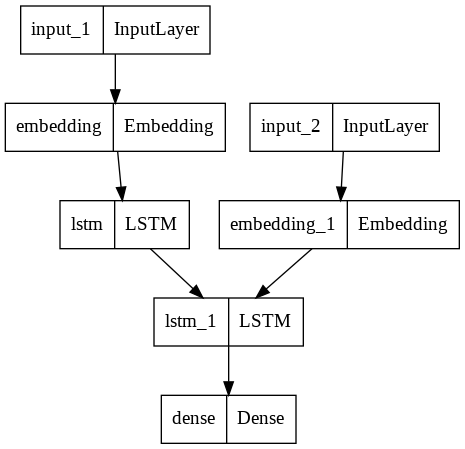

In [ ]:
# Построим график для визуализации слоев и связей между ними
plot_model(model)

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=256, epochs=10) 

Epoch 1/10
196/196 [==============================] - 640s 3s/step - loss: 1.3768
Epoch 2/10
196/196 [==============================] - 636s 3s/step - loss: 1.2688
Epoch 3/10
196/196 [==============================] - 639s 3s/step - loss: 1.1808
Epoch 4/10
196/196 [==============================] - 639s 3s/step - loss: 1.1058
Epoch 5/10
196/196 [==============================] - 639s 3s/step - loss: 1.0413
Epoch 6/10
196/196 [==============================] - 639s 3s/step - loss: 0.9832
Epoch 7/10
196/196 [==============================] - 643s 3s/step - loss: 0.9319
Epoch 8/10
196/196 [==============================] - 639s 3s/step - loss: 0.8884
Epoch 9/10
196/196 [==============================] - 638s 3s/step - loss: 0.8493
Epoch 10/10
196/196 [==============================] - 638s 3s/step - loss: 0.8107


In [ ]:
# Создаем рабочие модели для перевода

def makeInferenceModels():

  '''
  Функция для создания единой полноценной модели из энкодера и декодера
  Собираем по отдельности энкодер и декодер для использования метода .predict() для каждого из них в конце работы для проверки результатов

  Args:
    None
    
  Returns:
    Вовзращает рабочие модели энкодера и декодера для дальнейшей работы нейросети
  '''

  # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  # Создадим модель декодера
  decoderStateInput_h = Input(shape=(200 ,)) # Добавим входной слой для state_h
  decoderStateInput_c = Input(shape=(200 ,)) # Добавим входной слой для state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # Соберем оба inputs вместе и запишем в decoderStatesInputs

  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs) # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderStates = [state_h, state_c]            # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # И ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  # Вернем рабочие модели энкодера и декодера  
  return encoderModel , decoderModel

In [ ]:
#Сервисная функция для перевода произвольной фразы в токены. Функция разбирает фразу на слова.
#Для каждого слова находит свой индекс. Его подскажет токенайзер. 
#И дополняет полученный список индексов нулями до максимальной длины. Используется для подготовки фразы к ее переводу. 
#Принимает на вход строку, отдает список токенов

In [ ]:
def strToTokens(sentence: str):     # Функция принимает входную фразу

  '''
  Функция для очистки фразы и преобразования в индексы по словарю в токенайзере

  Args:
    sentence - фраза, формата str

  Returns:
    None, если незнакомые символы фразы
    Входная фраза в виде последовательности символов, если смогли определить индексы
  '''
  
  tmp_sent = my_replacer(sentence)                                              # Почистим фразу
  words = tmp_sent.lower().split()                                              # Приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list()                                                           # Здесь будет последовательность токенов/индексов

  # Для каждого слова в предложении
  for word in words:
    try:
        tokensList.append(tokenizer.word_index[word])                           # Определяем токенайзером индекс и добавляем в список
    except:
        pass                                                                    # Слова нет - просто игнорируем его

  # Вернёт входную фразу в виде последовательности индексов
  if tokensList:
    return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

  return None                                                                   # Фраза из незнакомх слов - вернем None 

In [ ]:
# Запускаем функцию для построения модели кодера и декодера

encModel , decModel = makeInferenceModels() 

In [ ]:
# Цикл по количеству входных фраз - их 1
for _ in range(1): # задаем количество вопросов, и на каждой итерации в этом диапазоне:

  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  decodedTranslation0 = input('Исходное предложение на английском: ')
  qua  = strToTokens(decodedTranslation0)

  if qua is None:                                      # В запросе сплошные незнакомые слова...
    print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
    continue                                           # Пойдем за следущей фразой

  statesValues = encModel.predict(qua)                 # Прогоним фразу через энкодер
  
  emptyTargetSeq = np.zeros((1, 1))                    # Создадим пустой массив
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # Положим в пустую последовательность начальное слово 'start' в виде индекса
  stopCondition = False                                # Зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = ''                              #Здесь будет собираться генерируемый ответ

  while not stopCondition:                             # пока не сработало стоп-условие

    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # Получим индекс предсказанного слова.
    sampledWord = None                                 # Создаем переменную, в которую положим слово, преобразованное на естественный язык

    # Цикл по всем индексам токенайзера
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index:              # Если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word                       # Выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # Срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1))       # Создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # Заносим туда индекс выбранного слова
    statesValues = [h, c]                   # И состояния, обновленные декодером 
                                            # И продолжаем цикл с обновленными параметрами
  
  print("Перевод: ", decodedTranslation) # Выводим ответ сгенерированный декодером

Исходное предложение на английском: After you.
1/1 [==============================] - 0s 24ms/step
Перевод:   вы вас тобой. end


In [ ]:
#Теперь модель для перевода с английского на русский. Для закрепления материала, сделаем все аналогично выше, но переименуем переменные.

In [ ]:
conversations2 = []                                # Заготовим список для пар фраз
with open("rus.txt", 'r', encoding='utf-8') as f: # Открываем файл словаря в режиме чтения
    lines2 = f.read().split('\n')                  # Читаем весь файл, режем на строки

# Цикл по строкам
for i,line in enumerate(lines2):
    if i>50000:                                         # Нам нужно только 50000 первых строк
      break                                             # Заканчиваем цикл
    try:
        input_text2, target_text2,_ = line.split("\t")    # Берем очередную строку, режем по символу табуляции
        conversations2.append([input_text2, target_text2]) # Заполняем список пар фраз
    except:
        continue                                        # если не получается - идем за следущей строкой

In [ ]:
print(conversations2)

[['Go.', 'Марш!'], ['Go.', 'Иди.'], ['Go.', 'Идите.'], ['Hi.', 'Здравствуйте.'], ['Hi.', 'Привет!'], ['Hi.', 'Хай.'], ['Hi.', 'Здрасте.'], ['Hi.', 'Здоро́во!'], ['Hi.', 'Приветик!'], ['Run!', 'Беги!'], ['Run!', 'Бегите!'], ['Run.', 'Беги!'], ['Run.', 'Бегите!'], ['Who?', 'Кто?'], ['Wow!', 'Вот это да!'], ['Wow!', 'Круто!'], ['Wow!', 'Здорово!'], ['Wow!', 'Ух ты!'], ['Wow!', 'Ого!'], ['Wow!', 'Вах!'], ['Duck!', 'Пригнись!'], ['Fire!', 'Огонь!'], ['Fire!', 'Пожар!'], ['Help!', 'Помогите!'], ['Help!', 'На помощь!'], ['Help!', 'Спасите!'], ['Hide.', 'Прячься.'], ['Hide.', 'Прячьтесь.'], ['Hide.', 'Спрячься.'], ['Hide.', 'Спрячьтесь.'], ['Jump!', 'Прыгай!'], ['Jump!', 'Прыгайте!'], ['Jump.', 'Прыгай!'], ['Jump.', 'Прыгайте!'], ['Stay.', 'Оставайся.'], ['Stay.', 'Оставайтесь.'], ['Stay.', 'Останься.'], ['Stay.', 'Останьтесь.'], ['Stop!', 'Стой!'], ['Stop!', 'Остановитесь!'], ['Stop!', 'Остановись!'], ['Wait!', 'Подожди!'], ['Wait!', 'Подождите!'], ['Wait!', 'Ждите!'], ['Wait!', 'Жди!'], ['Wa

In [ ]:
# Собираем вопросы и ответы в списки

questions2 = [] # Переменная для списка входных фраз
answers2 = []   # Переменная для списка ответных фраз

# Цикл по всем парам фраз 
for con in conversations2:                 
  if len(con) > 1 :                       # Если ответная фраза содержит более одно двух предложений
    questions2.append(my_replacer(con[1])) # То первую в списке фразу отправляем в список входных фраз
    replies2 = my_replacer(con[:1])        # А ответную составляем из последующих строк
    ans2 = ' '.join(replies2)               # Здесь соберем ответ
    answers2.append(ans2)                   # Добавим в список ответов
  else:
    continue                              # Иначе идем за новой парой фраз

# Добавим в каждую ответную фразу теги  <START> и <END>
answers2 = ['<START> ' + s + ' <END>' for s in answers2]

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions2[222])) # Пример входной фразы
print('Ответ : {}'.format(answers2[222]))    # Пример ответной фразы

Вопрос : Сожгите его.
Ответ : <START> Burn it. <END>


In [ ]:
# Создадим токенайзер 
tokenizer2 = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')  

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer2.fit_on_texts(questions2 + answers2)         

# Список с cодержимым словаря
vocabularyItems2 = list(tokenizer2.word_index.items())    

# Размер словаря
vocabularySize2 = len(vocabularyItems2)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems2[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize2)) 

Фрагмент словаря : [('start', 1), ('end', 2), ('я', 3), ('i', 4), ('tom', 5), ('том', 6), ('не', 7), ('это', 8), ('you', 9), ('is', 10), ('a', 11), ("i'm", 12), ('ты', 13), ('мне', 14), ('the', 15), ('it', 16), ('мы', 17), ('was', 18), ('to', 19), ('вы', 20), ('we', 21), ('у', 22), ('it.', 23), ('do', 24), ('в', 25), ('он', 26), ('меня', 27), ('tom.', 28), ("it's", 29), ('my', 30), ("don't", 31), ('you.', 32), ('are', 33), ('can', 34), ('me.', 35), ("you're", 36), ('your', 37), ('они', 38), ('на', 39), ('был', 40), ('he', 41), ('this', 42), ('did', 43), ('have', 44), ('not', 45), ('be', 46), ("i'll", 47), ('that', 48), ('go', 49), ('me', 50)]
Размер словаря : 26436


In [ ]:
# Разбиваем текст входных фраз на последовательности индексов
tokenizedQuestions2 = tokenizer2.texts_to_sequences(questions2)

# Уточняем длину самой длинной фразы
maxLenQuestions2 = max([ len(x) for x in tokenizedQuestions2])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
paddedQuestions2 = pad_sequences(tokenizedQuestions2, maxlen=maxLenQuestions2, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
encoderForInput2 = np.array(paddedQuestions2)        

# Выведем на экран
print('Пример входной фразы                         : {}'.format(questions2[100]))         
print('Пример кодированной входной фразы            : {}'.format(encoderForInput2[100]))  
print('Размеры закодированного массива входных фраз : {}'.format(encoderForInput2.shape))  
print('Установленная длина входных фраз             : {}'.format(maxLenQuestions2)) 

Пример входной фразы                         : Съешьте её.
Пример кодированной входной фразы            : [3535  295    0    0    0    0    0    0    0    0]
Размеры закодированного массива входных фраз : (50001, 10)
Установленная длина входных фраз             : 10


In [ ]:
# Разбиваем текст ответных фраз на последовательности индексов
tokenizedAnswers2 = tokenizer2.texts_to_sequences(answers2) 

# Уточняем длину самого длинного ответа
maxLenAnswers2 = max([len(x) for x in tokenizedAnswers2])

# Делаем последовательности одной длины, заполняя нулями более ответы
paddedAnswers2 = pad_sequences(tokenizedAnswers2, maxlen=maxLenAnswers2, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
decoderForInput2 = np.array(paddedAnswers2)               

# Выведем на экран
print('Пример оригинального ответа на вход: {}'.format(answers2[100]))                         
print('Пример кодированного ответа на вход : {}'.format(decoderForInput2[100][:30]))           
print('Размеры кодированного массива ответов на вход : {}'.format(decoderForInput2.shape))     
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers2))    

Пример оригинального ответа на вход: <START> Eat it. <END>
Пример кодированного ответа на вход : [  1 180  23   2   0   0   0   0]
Размеры кодированного массива ответов на вход : (50001, 8)
Установленная длина ответов на вход : 8


In [ ]:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers2 = tokenizer2.texts_to_sequences(answers2) 

for i in range(len(tokenizedAnswers2)) :                  # Для разбитых на последовательности ответов
  tokenizedAnswers2[i] = tokenizedAnswers2[i][1:]          # Избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers2 = pad_sequences(tokenizedAnswers2, maxlen=maxLenAnswers2 , padding='post') 

# И сохраняем в виде массива numpy
decoderForOutput2 = np.array(paddedAnswers2)     

In [ ]:
# Выведем на экран

print('Пример кодированного ответа на вход : {}'.format(decoderForInput2[100][:21]))   
print('Пример кодированного ответа на выход : {}'.format(decoderForOutput2[100][:21]))
print('Размеры кодированного массива ответов на выход : {}'.format(decoderForOutput2.shape))  
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers2)) 

Пример кодированного ответа на вход : [  1 180  23   2   0   0   0   0]
Пример кодированного ответа на выход : [180  23   2   0   0   0   0   0]
Размеры кодированного массива ответов на выход : (50001, 8)
Установленная длина вопросов на выход : 8


In [ ]:
# Создадим энкодер 

encoderInputs2 = Input(shape=(None , ))                                             # Добавим входной слой
encoderEmbedding2 = Embedding(vocabularySize2, 200 , mask_zero=True)(encoderInputs2)  # Добавим эмбеддинг
encoderOutputs2, state_h2 , state_c2 = LSTM(200, return_state=True)(encoderEmbedding2) # Добавим LSTM
encoderStates2 = [state_h2, state_c2]                                                 # Соберем выходы lstm  в список   

In [ ]:
# Создадим декодер 

decoderInputs2 = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding2 = Embedding(vocabularySize2, 200, mask_zero=True) (decoderInputs2)    # Добавим эмбеддинг
decoderLSTM2 = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs2 , _ , _ = decoderLSTM2 (decoderEmbedding2, initial_state=encoderStates2) # Прогоним выход embedding через LSTM
decoderDense2 = Dense(vocabularySize2, activation='softmax')                           # Создадим dense слой
output2 = decoderDense2 (decoderOutputs2)                                               # Прогоним  выход LSTM через DENSE

In [ ]:
model2 = Model([encoderInputs2, decoderInputs2], output2) # Собираем модель
model2.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy') # Компилиуем модель
print(model2.summary()) # Выведем на экран информацию о построенной модели нейросети

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 200)    5287200     ['input_5[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 200)    5287200     ['input_6[0][0]']                
                                                                                            

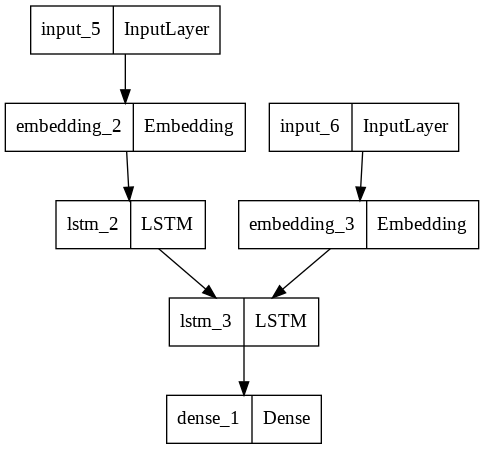

In [ ]:
# Построим график для визуализации слоев и связей между ними
plot_model(model2)

In [ ]:
# Запустим обучение
model2.fit([encoderForInput2 , decoderForInput2], decoderForOutput2, batch_size=256, epochs=10) 

Epoch 1/10
196/196 [==============================] - 456s 2s/step - loss: 2.9002
Epoch 2/10
196/196 [==============================] - 447s 2s/step - loss: 2.0932
Epoch 3/10
196/196 [==============================] - 448s 2s/step - loss: 1.8002
Epoch 4/10
196/196 [==============================] - 446s 2s/step - loss: 1.5966
Epoch 5/10
196/196 [==============================] - 448s 2s/step - loss: 1.4295
Epoch 6/10
196/196 [==============================] - 452s 2s/step - loss: 1.2928
Epoch 7/10
196/196 [==============================] - 448s 2s/step - loss: 1.1778
Epoch 8/10
196/196 [==============================] - 447s 2s/step - loss: 1.0786
Epoch 9/10
196/196 [==============================] - 455s 2s/step - loss: 0.9923
Epoch 10/10
196/196 [==============================] - 457s 2s/step - loss: 0.9144


In [ ]:
# Создаем рабочие модели для перевода

def makeInferenceModels2():

  '''
  Функция для создания единой полноценной модели из энкодера и декодера
  Собираем по отдельности энкодер и декодер для использования метода .predict() для каждого из них в конце работы для проверки результатов

  Args:
    None
    
  Returns:
    Вовзращает рабочие модели энкодера и декодера для дальнейшей работы нейросети
  '''

  # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
  encoderModel2 = Model(encoderInputs2, encoderStates2) 

  # Создадим модель декодера
  decoderStateInput_h = Input(shape=(200 ,)) # Добавим входной слой для state_h
  decoderStateInput_c = Input(shape=(200 ,)) # Добавим входной слой для state_c

  decoderStatesInputs2 = [decoderStateInput_h, decoderStateInput_c] # Соберем оба inputs вместе и запишем в decoderStatesInputs

  decoderOutputs2, state_h, state_c = decoderLSTM(decoderEmbedding2, initial_state=decoderStatesInputs2) # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderStates2 = [state_h, state_c]            # LSTM даст нам новые состояния
  decoderOutputs2 = decoderDense(decoderOutputs2) # И ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel2 = Model([decoderInputs2] + decoderStatesInputs2, [decoderOutputs2] + decoderStates2)

  # Вернем рабочие модели энкодера и декодера  
  return encoderModel2 , decoderModel2

In [ ]:
def strToTokens(sentence2: str):     # Функция принимает входную фразу

  '''
  Функция для очистки фразы и преобразования в индексы по словарю в токенайзере

  Args:
    sentence - фраза, формата str

  Returns:
    None, если незнакомые символы фразы
    Входная фраза в виде последовательности символов, если смогли определить индексы
  '''
  
  tmp_sent2 = my_replacer(sentence2)                                              # Почистим фразу
  words2 = tmp_sent2.lower().split()                                              # Приводит предложение к нижнему регистру и разбирает на слова
  tokensList2 = list()                                                           # Здесь будет последовательность токенов/индексов

  # Для каждого слова в предложении
  for word2 in words2:
    try:
        tokensList2.append(tokenizer.word_index[word])                           # Определяем токенайзером индекс и добавляем в список
    except:
        pass                                                                    # Слова нет - просто игнорируем его

  # Вернёт входную фразу в виде последовательности индексов
  if tokensList2:
    return pad_sequences([tokensList2], maxlen=maxLenQuestions2 , padding='post')

  return None                                                                   # Фраза из незнакомх слов - вернем None 

In [ ]:
# Запускаем функцию для построения модели кодера и декодера

encModel2 , decModel2 = makeInferenceModels2() 

In [ ]:
# Цикл по количеству входных фраз - их 1
for _ in range(1): # задаем количество вопросов, и на каждой итерации в этом диапазоне:

  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  decodedTranslation2 = input('Исходное предложение на русском: ')
  qua2  = strToTokens(decodedTranslation2)

  if qua2 is None:                                      # В запросе сплошные незнакомые слова...
    print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
    continue                                           # Пойдем за следущей фразой

  statesValues2 = encModel2.predict(qua)                 # Прогоним фразу через энкодер
  
  emptyTargetSeq2 = np.zeros((1, 1))                    # Создадим пустой массив
  emptyTargetSeq2[0, 0] = tokenizer.word_index['start'] # Положим в пустую последовательность начальное слово 'start' в виде индекса
  stopCondition2 = False                                # Зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation2 = ''                              #Здесь будет собираться генерируемый ответ

  while not stopCondition2:                             # пока не сработало стоп-условие

    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs2 , h2 , c2 = decModel.predict([emptyTargetSeq2] + statesValues2)
    
    sampledWordIndex2 = np.argmax( decOutputs2[0, 0, :]) # Получим индекс предсказанного слова.
    sampledWord2 = None                                 # Создаем переменную, в которую положим слово, преобразованное на естественный язык

    # Цикл по всем индексам токенайзера
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex2 == index:              # Если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation2 += ' {}'.format(word) # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord2 = word                       # Выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord2 == 'end' or len(decodedTranslation2.split()) > maxLenAnswers2:
      stopCondition2 = True # Срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq2 = np.zeros((1, 1))       # Создаем пустой массив
    emptyTargetSeq2[0, 0] = sampledWordIndex2 # Заносим туда индекс выбранного слова
    statesValues2 = [h2, c2]                   # И состояния, обновленные декодером 
                                            # И продолжаем цикл с обновленными параметрами
  
  print("Перевод: ", decodedTranslation2) # Выводим ответ сгенерированный декодером

Исходное предложение на русском: После тебя
1/1 [==============================] - 0s 27ms/step
Перевод:   стол. end
